## GLUCOSE PREDICTION : MODEL => Gradient Boosting : XGBOOST

In [ ]:
%pip install pandas numpy scikit-learn xgboost matplotlib seaborn

### LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


# For scaling and model training
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import xgboost as xgb
print(xgb.__version__)

2.1.2


#### DATA INPUT AND PROCESSING

In [3]:
data_path = './Final_Dataset/glucose_dataset.csv'

In [4]:
data = pd.read_csv(data_path)

data.head()

,Diabetes,HighBP,HighChol,CholCheck,BMI,smoking,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,drinking,family_histroy
0,0,0.0,0.0,1.0,25.0,0,0.0,0.0,1.0,1.0,...,3.83,1.04,1.06,2.24,126.1,5.94,83.0,4.34,0,0
1,0,0.0,0.0,1.0,25.0,0,0.0,0.0,1.0,1.0,...,3.83,1.04,1.06,2.24,126.1,5.94,83.0,4.34,0,0
2,0,0.0,0.0,1.0,25.0,0,0.0,0.0,1.0,1.0,...,3.83,1.04,1.06,2.24,126.1,5.94,83.0,4.34,0,0
3,0,0.0,0.0,1.0,25.0,0,0.0,0.0,1.0,1.0,...,3.83,1.04,1.06,2.24,126.1,5.94,83.0,4.34,0,0
4,0,0.0,0.0,1.0,25.0,0,0.0,0.0,0.0,1.0,...,3.83,1.04,1.06,2.24,126.1,5.94,83.0,4.34,0,0


In [6]:
# Display basic information
data.columns



Index(['Diabetes', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'smoking',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Gender', 'Age', 'Education',
       'Income', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT',
       'BUN', 'CCR', 'FFPG', 'drinking', 'family_histroy'],
      dtype='object')

In [9]:
# Summary statistics
print(data.describe())



            Diabetes         HighBP       HighChol      CholCheck  \
count  199948.000000  199948.000000  199948.000000  199948.000000   
mean        0.004481       0.213626       0.288550       0.936283   
std         0.066792       0.409866       0.453089       0.244248   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       0.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

                 BMI        smoking         Stroke  HeartDiseaseorAttack  \
count  199948.000000  199948.000000  199948.000000         199948.000000   
mean       24.553029       0.250250       0.018755              0.030948   
std         2.638461       0.433158       0.135658              0.173177   
min        16.000000       0.000000       0.000000              0.000000  

In [10]:

# Check for missing values
print(data.isnull().sum())

Diabetes                0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
smoking                 0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Gender                  0
Age                     0
Education               0
Income                  0
SBP                     0
DBP                     0
FPG                     0
Chol                    0
Tri                     0
HDL                     0
LDL                     0
ALT                     0
BUN                     0
CCR                     0
FFPG                    0
drinking                0
family_histroy          0
dtype: int64


### VISUALIZING FEATURE DISTRIBUTION:

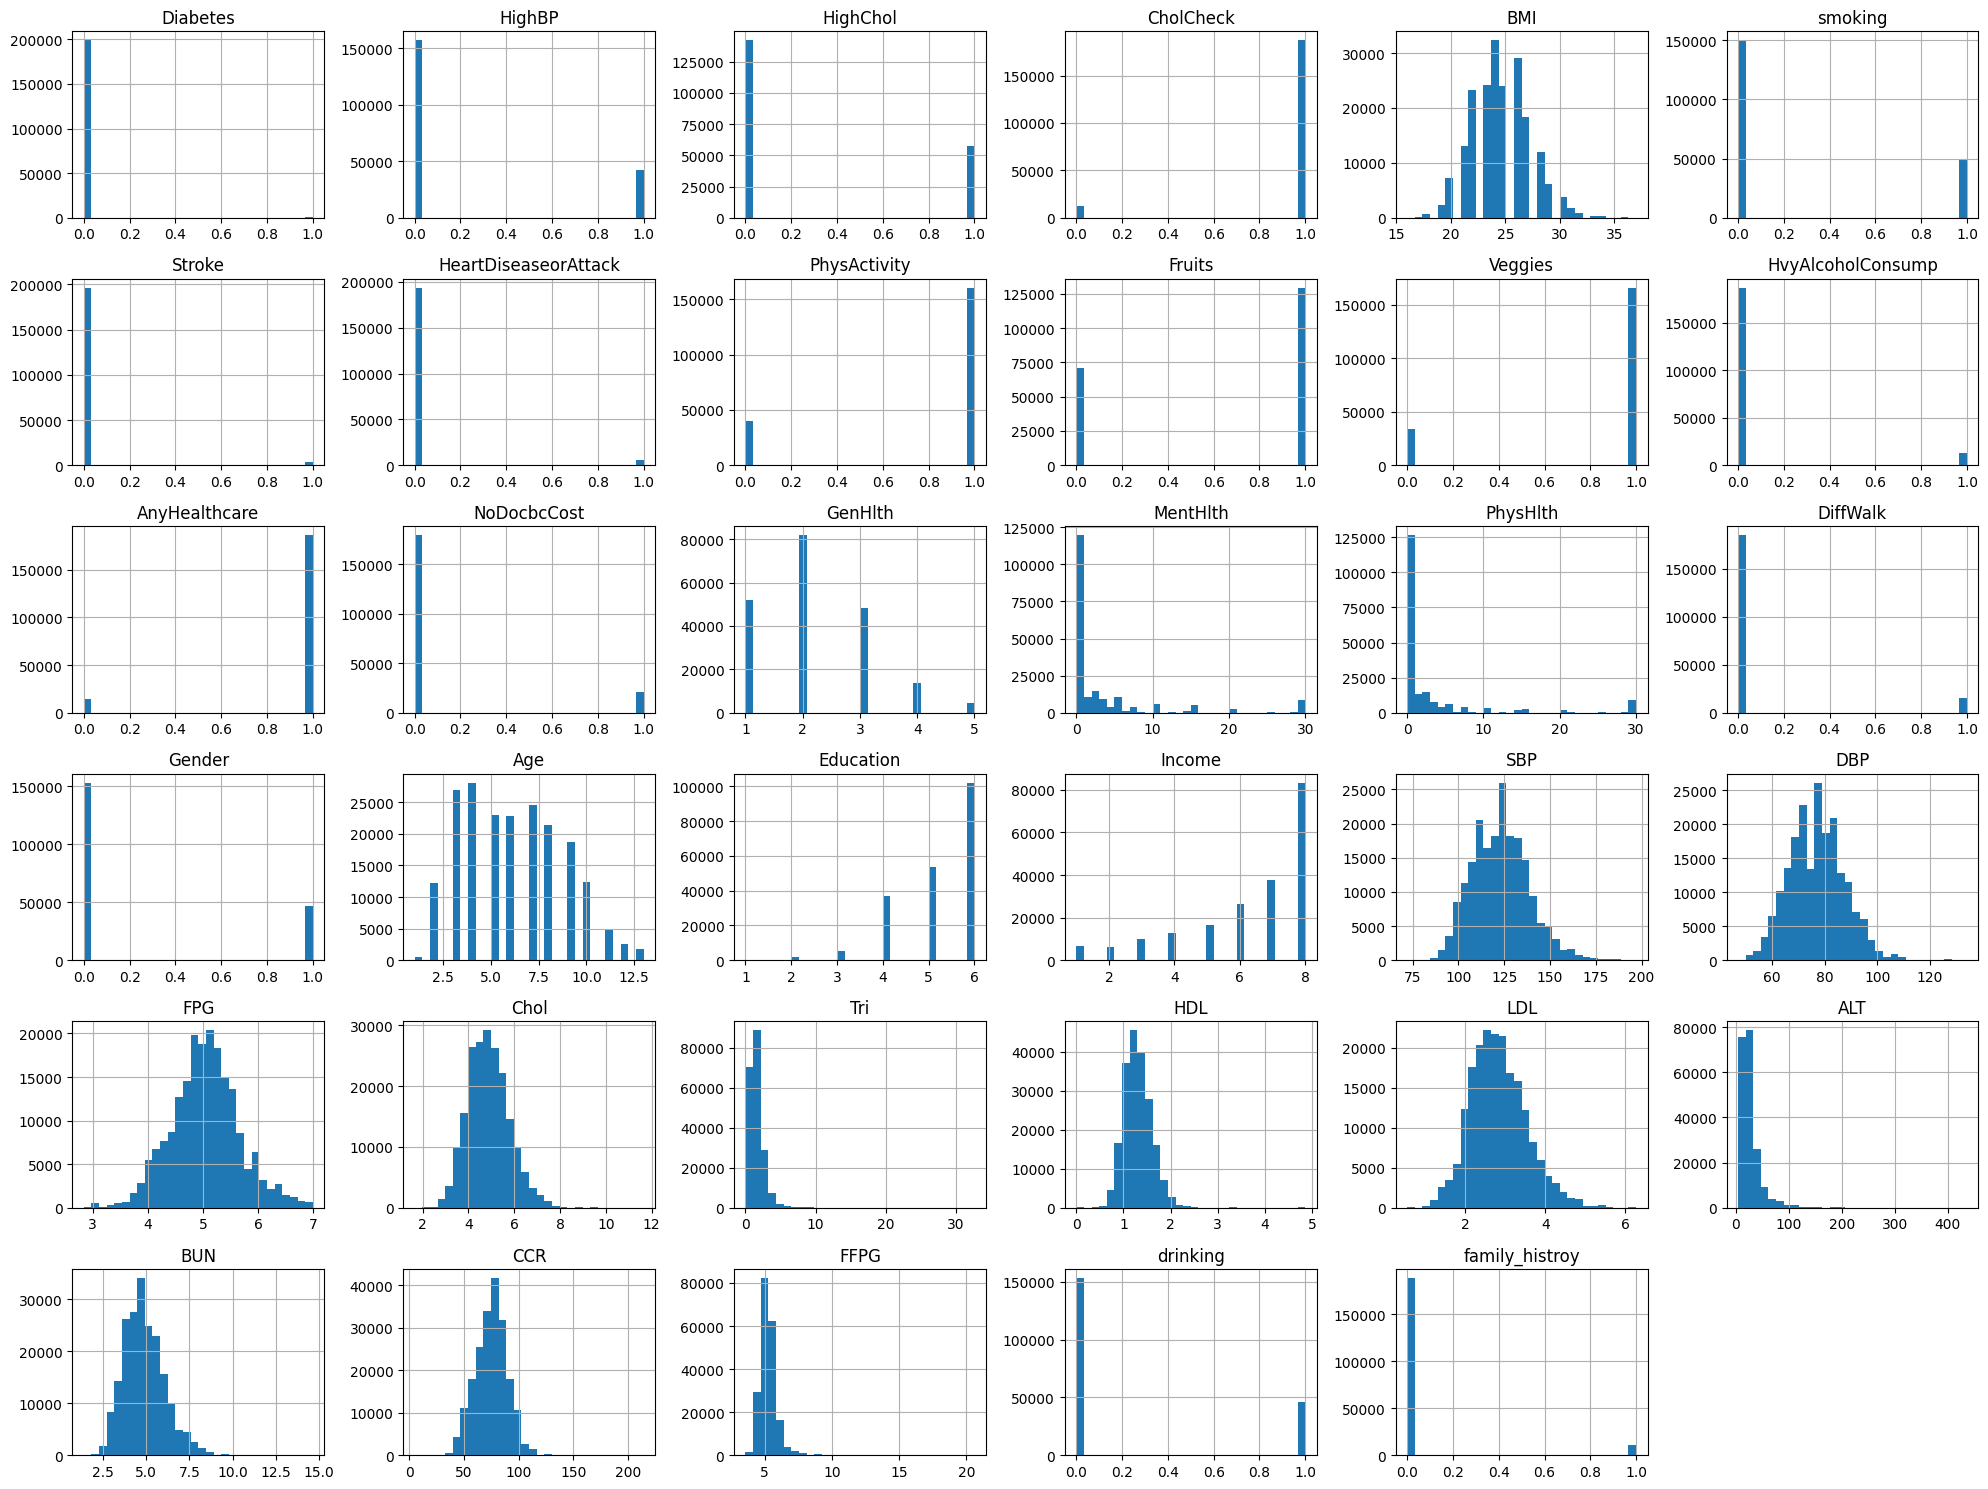

In [11]:
# List of numerical features (update based on your dataset)
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove the target variables 'fpg' and 'ffpg' from the list
target_columns = ['fpg', 'ffpg']  # Update based on your actual target column names
for target in target_columns:
    if target in numerical_features:
        numerical_features.remove(target)

# Plot histograms
data[numerical_features].hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()


### DATA CLEANING

In [12]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])


Series([], dtype: int64)


In [13]:
from sklearn.multioutput import MultiOutputRegressor

# For saving the model
import joblib

In [14]:
from sklearn.impute import SimpleImputer

In [15]:
target_columns = ['fpg', 'ffpg']  # Update based on your target column names
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
for target in target_columns:
    if target in numerical_features:
        numerical_features.remove(target)

In [16]:
targets = ['FPG', 'FFPG']

In [17]:
features = [col for col in numerical_features if col not in targets]

In [18]:
epsilon = 1e-6

In [19]:
if 'Tri' in data.columns and 'HDL' in data.columns:
    data['LipidRatio'] = data['Tri'] / (data['HDL'] + epsilon)
    features.append('LipidRatio')
    print("LipidRatio created with epsilon to prevent division by zero.")


LipidRatio created with epsilon to prevent division by zero.


In [20]:
if 'fpg' in data.columns and 'ffpg' in data.columns:
    data['GlucoseControl'] = (data['fpg'] + data['ffpg']) / 2
    features.append('GlucoseControl')
    print("GlucoseControl feature created.")

In [21]:
if all(col in data.columns for col in ['PhysActivity', 'Fruits', 'Veggies']):
    data['LifestyleIndex'] = data[['PhysActivity', 'Fruits', 'Veggies']].mean(axis=1)
    features.append('LifestyleIndex')
    print("LifestyleIndex feature created.")

LifestyleIndex feature created.


In [22]:
if all(col in data.columns for col in ['HighBP', 'LipidRatio', 'GlucoseControl', 'LifestyleIndex']):
    data['BP_LipidInteraction'] = data['HighBP'] * data['LipidRatio']
    data['Glucose_LifestyleInteraction'] = data['GlucoseControl'] * data['LifestyleIndex']
    features += ['BP_LipidInteraction', 'Glucose_LifestyleInteraction']
    print("Interaction features created.")

In [23]:
from sklearn.feature_selection import VarianceThreshold

In [24]:
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
data_reduced = selector.fit_transform(data[features])
selected_features = data[features].columns[selector.get_support()].tolist()
print("Selected features after variance threshold:", selected_features)

Selected features after variance threshold: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'smoking', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Gender', 'Age', 'Education', 'Income', 'SBP', 'DBP', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'drinking', 'family_histroy', 'LipidRatio', 'LifestyleIndex']


In [25]:
corr_matrix = data[selected_features].corr().abs()


In [26]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [27]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Highly correlated features to drop:", to_drop)

Highly correlated features to drop: []


In [28]:
data = data.drop(columns=to_drop)
features = [col for col in selected_features if col not in to_drop]
print("Features after removing highly correlated ones:", features)

Features after removing highly correlated ones: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'smoking', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Gender', 'Age', 'Education', 'Income', 'SBP', 'DBP', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'drinking', 'family_histroy', 'LipidRatio', 'LifestyleIndex']


In [29]:
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
print("Feature scaling applied.")

Feature scaling applied.


In [30]:
# b. Dimensionality Reduction with PCA (Optional)
apply_pca = False  # Set to True to apply PCA

In [31]:
if apply_pca:
    # Initialize PCA to retain 95% variance
    pca = PCA(n_components=0.95, random_state=42)

    # Fit PCA on the feature set
    X_pca_full = pca.fit_transform(data[features])

    # Number of components retained
    print(f'Number of principal components retained: {pca.n_components_}')

    # Optional: Visualize explained variance
    plt.figure(figsize=(10,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by PCA Components')
    plt.grid(True)
    plt.show()

    # Update feature matrix
    pca_features = [f'PC{i+1}' for i in range(pca.n_components_)]
    X = pd.DataFrame(X_pca_full, columns=pca_features)
    print("PCA applied to the feature set.")
else:
    # Use the scaled features directly
    X = data[features].copy()
    print("Using scaled features without PCA.")

Using scaled features without PCA.


In [32]:
y = data[targets]

In [33]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.median(), inplace=True)
print("Replaced infinities with NaN and imputed missing values.")


Replaced infinities with NaN and imputed missing values.


In [34]:
if np.isinf(X).values.any():
    raise ValueError("Infinities detected in the feature set after preprocessing.")

In [35]:
if X.isnull().values.any():
    raise ValueError("NaNs detected in the feature set after preprocessing.")

In [36]:
print("Data cleaning and preprocessing completed successfully.")

Data cleaning and preprocessing completed successfully.


### MODEL TRAINING 

In [37]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
print(f'Training + Validation set size: {X_train_val.shape}')
print(f'Test set size: {X_test.shape}')

Training + Validation set size: (159958, 34)
Test set size: (39990, 34)


In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

print(f'Training set size: {X_train.shape}')
print(f'Validation set size: {X_val.shape}')
print(f'Test set size: {X_test.shape}')

Training set size: (119968, 34)
Validation set size: (39990, 34)
Test set size: (39990, 34)


In [40]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV


In [41]:
# Initialize XGBoost Regressor with default parameters
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # Suitable for regression tasks
    n_estimators=100,              # Number of trees
    learning_rate=0.1,             # Step size shrinkage
    max_depth=6,                   # Maximum tree depth
    subsample=0.8,                 # Subsample ratio of the training instance
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    random_state=42,               # Seed for reproducibility
    n_jobs=-1                       # Use all available cores
)


In [42]:
# Initialize MultiOutputRegressor with XGBoost
multi_xgb = MultiOutputRegressor(xgb_reg)


In [43]:
multi_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [44]:
param_distributions = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.7, 0.8, 0.9],
    'estimator__colsample_bytree': [0.7, 0.8, 0.9],
    'estimator__gamma': [0, 0.1, 0.2],
    'estimator__reg_alpha': [0, 0.01, 0.1],
    'estimator__reg_lambda': [1, 1.5, 2]
}

In [45]:
random_search = RandomizedSearchCV(
    estimator=multi_xgb,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,  # Number of cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [46]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=0.8,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types=None,
                                                                         gamma=None,
                                                                         grow_policy=None,
                                                                         importance_type=None,
                                                                         interaction_c...
                   param_distributions={'estimator__colsample_bytree': [0.7,
                                                                        0.8,
                                                                        0.9],
                                        'estimator__gamma': [0, 0.1, 0.2],
                                        'estimator__learning_rate': [0.01, 0.05,
                                                                     0.1],
                                        'estimator__max_depth': [3, 5, 7],
                                        'estimator__n_estimators': [100, 200,
                                                                    300],
                                        'estimator__reg_alpha': [0, 0.01, 0.1],
                                        'estimator__reg_lambda': [1, 1.5, 2],
                                        'estimator__subsample': [0.7, 0.8,
                                                                 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [47]:
print("Randomized search completed.")

# Best parameters found
print("Best parameters found: ", random_search.best_params_)

# Best estimator
best_multi_xgb = random_search.best_estimator_

Randomized search completed.
Best parameters found:  {'estimator__subsample': 0.8, 'estimator__reg_lambda': 2, 'estimator__reg_alpha': 0.01, 'estimator__n_estimators': 300, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.05, 'estimator__gamma': 0.1, 'estimator__colsample_bytree': 0.9}


In [48]:
print("Best Model Parameters:")
print(best_multi_xgb.estimator.get_params())

Best Model Parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 2, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


### MODEL EVALUATION

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on the validation set
y_val_pred = best_multi_xgb.predict(X_val)

# Evaluate performance for each target
for idx, target in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_val[target], y_val_pred[:, idx]))
    mae = mean_absolute_error(y_val[target], y_val_pred[:, idx])
    r2 = r2_score(y_val[target], y_val_pred[:, idx])
    
    print(f'\nValidation - Target: {target}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'R² Score: {r2:.2f}')



Validation - Target: FPG
RMSE: 0.17
MAE: 0.12
R² Score: 0.93

Validation - Target: FFPG
RMSE: 0.18
MAE: 0.12
R² Score: 0.93


In [50]:
# Predict on the test set
y_test_pred = best_multi_xgb.predict(X_test)

# Evaluate performance for each target
for idx, target in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test[target], y_test_pred[:, idx]))
    mae = mean_absolute_error(y_test[target], y_test_pred[:, idx])
    r2 = r2_score(y_test[target], y_test_pred[:, idx])
    
    print(f'\nTest - Target: {target}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'R² Score: {r2:.2f}')



Test - Target: FPG
RMSE: 0.17
MAE: 0.12
R² Score: 0.93

Test - Target: FFPG
RMSE: 0.18
MAE: 0.12
R² Score: 0.93


### FEATURE IMPORTANCE GRAPH


Feature Importance for FPG:


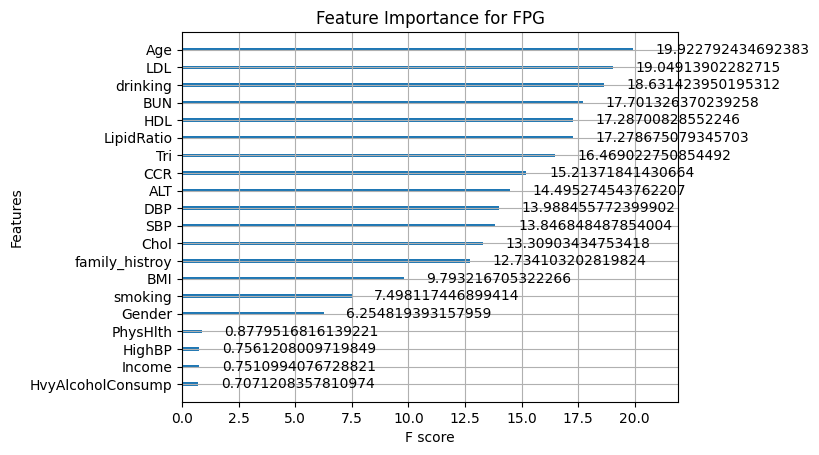


Feature Importance for FFPG:


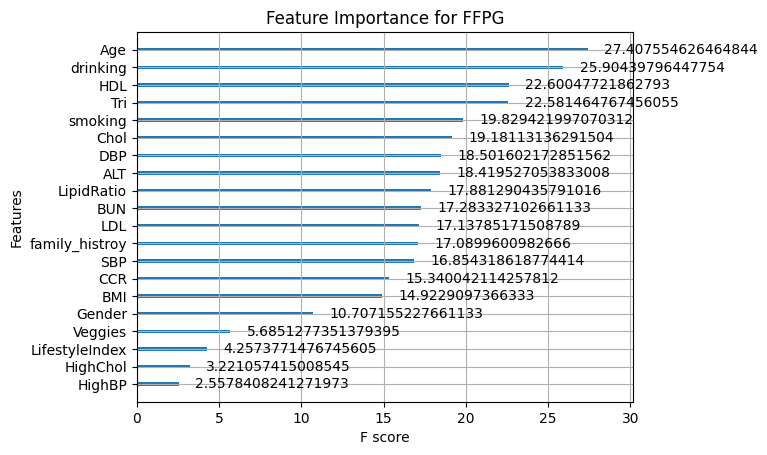

In [51]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance for each target
for i, target in enumerate(targets):
    print(f'\nFeature Importance for {target}:')
    # Get the estimator for the current target
    estimator = best_multi_xgb.estimators_[i]
    
    # Plot feature importance
    xgb.plot_importance(estimator, max_num_features=20, importance_type='gain')
    plt.title(f'Feature Importance for {target}')
    plt.show()


### CREATING PKL FILE FOR THE MODEL

In [52]:
# joblib.dump(best_multi_xgb , 'glucose_prediction_model_boosting.pkl')

['glucose_prediction_model_boosting.pkl']

## 2nd Attempt on MODEL CREATION

In [7]:
df = data[['Age' , 'Gender' , 'drinking' , 'smoking' , 'FPG' , 'FFPG' , 'BMI' , 'Chol' , 'HDL' , 'BUN' , 'Tri' , 'CCR' , 'LDL' , 'SBP' , 'DBP']]

In [8]:
df.head()

,Age,Gender,drinking,smoking,FPG,FFPG,BMI,Chol,HDL,BUN,Tri,CCR,LDL,SBP,DBP
0,3,0,0,0,2.84,4.34,25.0,3.83,1.06,5.94,1.04,83.0,2.24,115,78
1,3,0,0,0,2.84,4.34,25.0,3.83,1.06,5.94,1.04,83.0,2.24,115,78
2,3,0,0,0,2.84,4.34,25.0,3.83,1.06,5.94,1.04,83.0,2.24,115,78
3,3,0,0,0,2.84,4.34,25.0,3.83,1.06,5.94,1.04,83.0,2.24,115,78
4,3,0,0,0,2.84,4.34,25.0,3.83,1.06,5.94,1.04,83.0,2.24,115,78


### MODEL TRAINING

In [ ]:
X_train_val1 , X_test1 , y_train_val1 , y_test1 = train_test_split(X , y )

In [9]:
df.columns

Index(['Age', 'Gender', 'drinking', 'smoking', 'FPG', 'FFPG', 'BMI', 'Chol',
       'HDL', 'BUN', 'Tri', 'CCR', 'LDL', 'SBP', 'DBP'],
      dtype='object')

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [12]:

# Define features and target variable
features = ['Age', 'Gender', 'drinking', 'smoking', 'BMI', 'Chol', 'HDL', 'BUN', 'Tri', 'CCR', 'LDL', 'SBP', 'DBP']
target = ['FPG' , 'FFPG']  

# Separate features and target
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=50, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model - Mean Squared Error: {mse_best}')
print(f'Best Model - R-squared: {r2_best}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'colsample_bytree': np.float64(0.8475275087984799), 'learning_rate': np.float64(0.15564326972237194), 'max_depth': 7, 'n_estimators': 215, 'subsample': np.float64(0.9966846281789686)}
Best Model - Mean Squared Error: 0.006564504199163209
Best Model - R-squared: 0.9844704866409302


In [23]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE: {-cv_scores.mean()}')



Cross-Validation MSE: 0.6291908649523693


     Feature  Importance
11       SBP    0.103559
10       LDL    0.102889
6        HDL    0.098715
8        Tri    0.093354
7        BUN    0.088411
12       DBP    0.082896
5       Chol    0.082698
2   drinking    0.081529
9        CCR    0.077760
4        BMI    0.067848
0        Age    0.055714
3    smoking    0.043578
1     Gender    0.021049


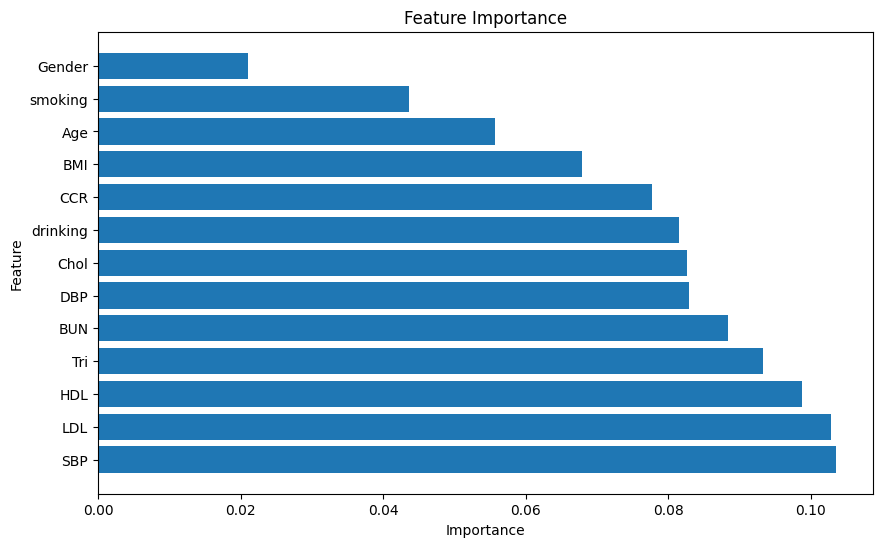

In [24]:
# Feature Importance
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [26]:
import joblib

In [27]:

joblib.dump(best_model , 'model_regressor.pkl')

['model_regressor.pkl']